## 🌐 Connect Colab to Google Drive

In [64]:
from google.colab import drive

drive.mount("/gdrive")
%cd /gdrive/MyDrive/UNI_Magistrale/ANN&DL/homework2/

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/Othercomputers/Il mio laptop/uni/ANN&DL/homework2


## ⚙️ Import Libraries

In [65]:
# Set seed for reproducibility
seed = 42

import os
from datetime import datetime

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import logging
import numpy as np
import random
import pandas as pd

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)


import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)


import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle


print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tfk.__version__}")
print(f"GPU devices: {len(tf.config.list_physical_devices('GPU'))}")

TensorFlow version: 2.17.1
Keras version: 3.5.0
GPU devices: 1


### Data cleaning

While plotting the images and their corresponding segmentations from the original training set, mars_for_students.npz, we identified some outliers (images containing an alien). We also observed that the outlier images (samples in X_train) differ from each other, whereas their corresponding segmentations are identical.  
To avoid processing the outliers in the future, we created a new dataset, cleaned_dataset.npz, which excludes these outliers.

In [66]:
"""
data = np.load("mars_for_students.npz")

training_set = data["training_set"]
X_train = training_set[:, 0]
y_train = training_set[:, 1]

X_test = data["test_set"]

print(f"Training X shape: {X_train.shape}")
print(f"Training y shape: {y_train.shape}")
print(f"Test X shape: {X_test.shape}")
"""

'\ndata = np.load("mars_for_students.npz")\n\ntraining_set = data["training_set"]\nX_train = training_set[:, 0]\ny_train = training_set[:, 1]\n\nX_test = data["test_set"]\n\nprint(f"Training X shape: {X_train.shape}")\nprint(f"Training y shape: {y_train.shape}")\nprint(f"Test X shape: {X_test.shape}")\n'

In [67]:
"""
# function that returns the list of the outliars' indices in y_train
# idx is the index corresponding to an outliar (found by visualization)

def find_outliers_idx(y_train, idx):
    # Extract the reference outlier
    outlier_reference = y_train[idx]

    # Initialize a list to store the indices of the outliers
    outliers_indices = []

    for i in range(y_train.shape[0]):
        if np.array_equal(y_train[i], outlier_reference):
            # If they are the same, add index i to the list of outlier indices
            outliers_indices.append(i)

    return outliers_indices


outlier_indices = find_outliers_idx(y_train, 62)
print(f"Number of outliers: {len(outlier_indices)}")
print("Indices of outliers:", outlier_indices)
"""

'\n# function that returns the list of the outliars\' indices in y_train\n# idx is the index corresponding to an outliar (found by visualization)\n\ndef find_outliers_idx(y_train, idx):\n    # Extract the reference outlier \n    outlier_reference = y_train[idx]\n    \n    # Initialize a list to store the indices of the outliers\n    outliers_indices = []\n\n    for i in range(y_train.shape[0]):\n        if np.array_equal(y_train[i], outlier_reference):\n            # If they are the same, add index i to the list of outlier indices\n            outliers_indices.append(i)\n  \n    return outliers_indices\n\n\noutlier_indices = find_outliers_idx(y_train, 62)\nprint(f"Number of outliers: {len(outlier_indices)}")\nprint("Indices of outliers:", outlier_indices)\n'

In [68]:
"""
# Plot the first four outliars

for i in outlier_indices[:4]:
  _, axs = plt.subplots(1, 2, figsize=(10, 5))
  axs[0].imshow(X_train[i], cmap='gray')
  axs[0].set_title(f'Image {i}')
  axs[0].axis('off')
  axs[1].imshow(y_train[i])
  axs[1].set_title(f'Segmentation {i}')
  plt.axis('off')
  plt.show()
"""

"\n# Plot the first four outliars\n\nfor i in outlier_indices[:4]:\n  _, axs = plt.subplots(1, 2, figsize=(10, 5))\n  axs[0].imshow(X_train[i], cmap='gray')\n  axs[0].set_title(f'Image {i}')\n  axs[0].axis('off')\n  axs[1].imshow(y_train[i])\n  axs[1].set_title(f'Segmentation {i}')\n  plt.axis('off')\n  plt.show()\n"

In [69]:
"""
# Remove outliers
X_train_cleaned = np.delete(X_train, outlier_indices, axis=0)
y_train_cleaned = np.delete(y_train, outlier_indices, axis=0)

print(f"X_train_cleaned shape: {X_train_cleaned.shape}")
print(f"y_train_cleaned shape: {y_train_cleaned.shape}")

# Save cleaned dataset
np.savez("data/cleaned_dataset.npz", training_set=np.stack((X_train_cleaned, y_train_cleaned), axis=1), test_set=X_test)
print("Saved cleaned dataset to 'cleaned_dataset.npz'.")
"""

'\n# Remove outliers\nX_train_cleaned = np.delete(X_train, outlier_indices, axis=0)\ny_train_cleaned = np.delete(y_train, outlier_indices, axis=0)\n\nprint(f"X_train_cleaned shape: {X_train_cleaned.shape}")\nprint(f"y_train_cleaned shape: {y_train_cleaned.shape}")\n\n# Save cleaned dataset\nnp.savez("data/cleaned_dataset.npz", training_set=np.stack((X_train_cleaned, y_train_cleaned), axis=1), test_set=X_test)\nprint("Saved cleaned dataset to \'cleaned_dataset.npz\'.")\n'

# ⏳ Load and Process Data

In [70]:
data = np.load("cleaned_dataset.npz")

training_set = data["training_set"]
X_train_val = training_set[:, 0]
y_train_val = training_set[:, 1]

X_test = data["test_set"]

# Add color channel and rescale pixels between 0 and 1
X_train_val = X_train_val[..., np.newaxis] / 255.0
X_test = X_test[..., np.newaxis] / 255.0

print(f"X_train_val shape: {X_train_val.shape}")
print(f"y_train_val shape: {y_train_val.shape}")
print(f"X_test shape: {X_test.shape}")

X_train_val shape: (2505, 64, 128, 1)
y_train_val shape: (2505, 64, 128)
X_test shape: (10022, 64, 128, 1)


In [71]:
NUM_CLASSES = len(np.unique(y_train_val))
input_shape = X_train_val.shape[1:]

# Define a mapping of labels to their corresponding digit names
labels = {0: "Background", 1: "Soil", 2: "Bedrock", 3: "Sand", 4: "Big Rock"}
labels_name = list(labels.values())

print(f"Input shape: {input_shape}")
print(f"Number of classes: {NUM_CLASSES}")
print('\nClasses: ', labels)

Input shape: (64, 128, 1)
Number of classes: 5

Classes:  {0: 'Background', 1: 'Soil', 2: 'Bedrock', 3: 'Sand', 4: 'Big Rock'}


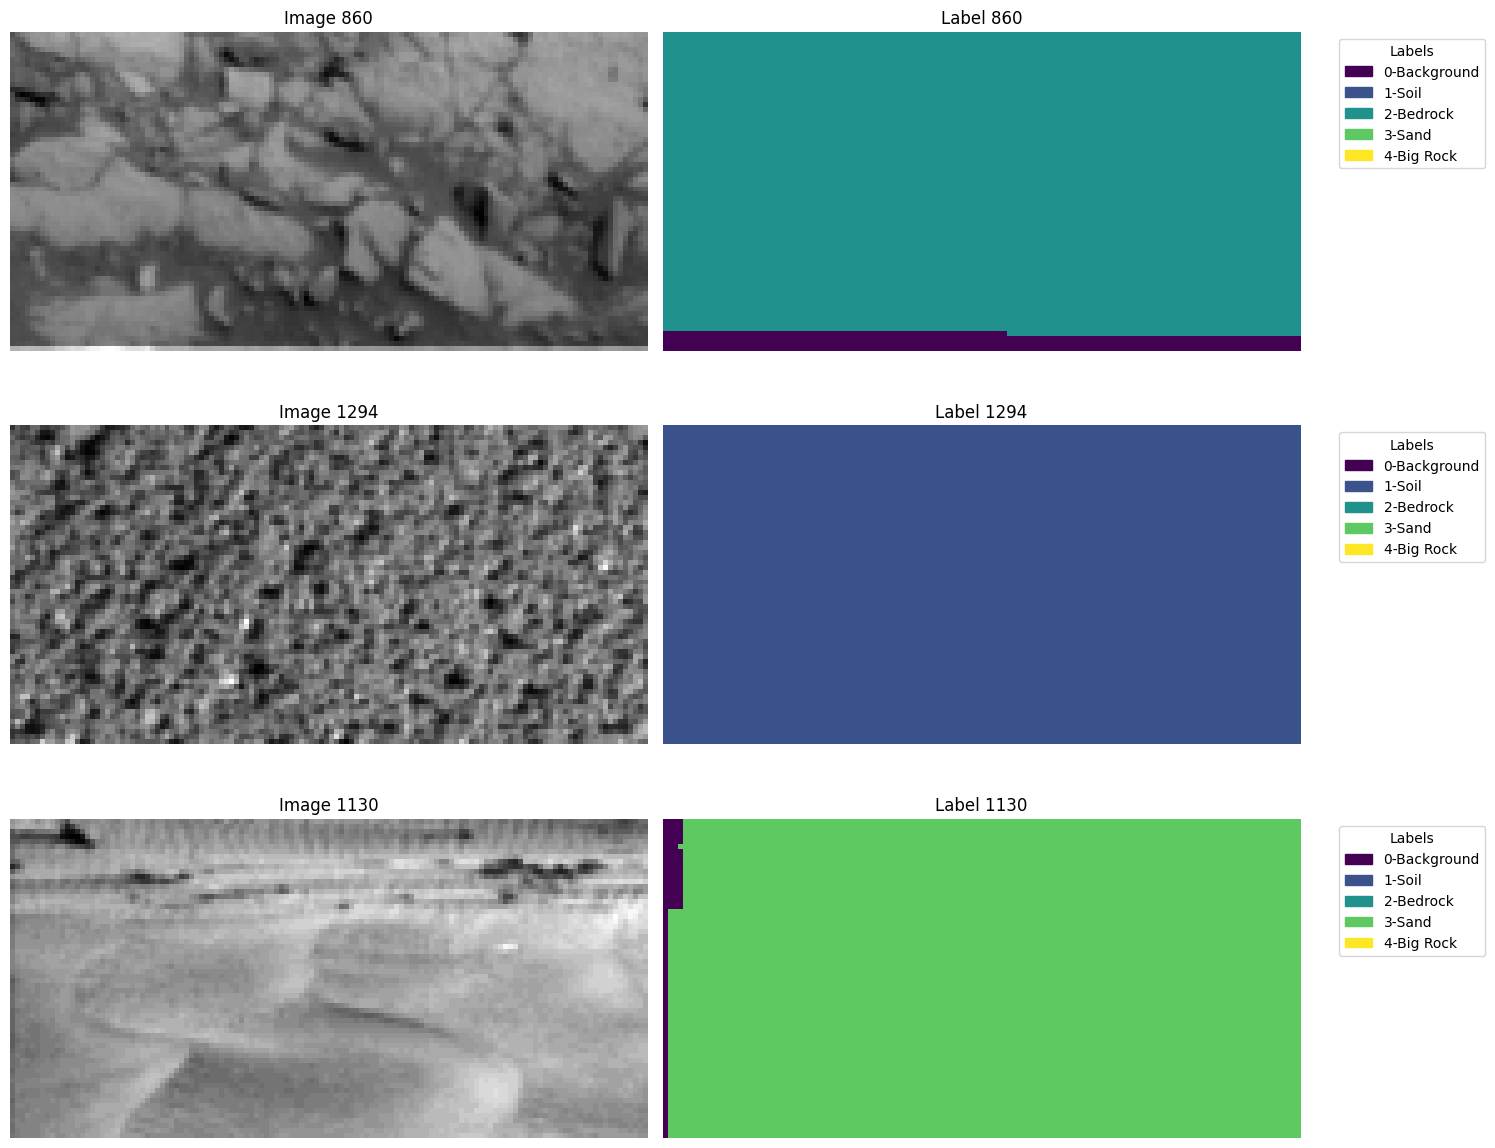

In [72]:
def create_segmentation_colormap(num_classes):
    """
    Create a linear colormap using a predefined palette.
    Uses 'viridis' as default because it is perceptually uniform
    and works well for colorblindness.
    """
    return plt.cm.viridis(np.linspace(0, 1, num_classes))



def apply_colormap(label, colormap=None):
    """
    Apply the colormap to a label.
    """
    # Ensure label is 2D
    label = np.squeeze(label)

    if colormap is None:
        num_classes = len(np.unique(label))
        colormap = create_segmentation_colormap(num_classes)

    # Apply the colormap
    colored = colormap[label.astype(int)]
    return colored



def add_colormap_legend(colormap, num_classes, labels_name):
    """
    Add a legend to the plot to show the mapping between labels and colors.

    Parameters:
    - colormap: The colormap used for segmentation.
    - num_classes: Number of classes.
    """
    patches = []
    for i in range(num_classes):
        color = colormap[i][:3]  # RGB values
        label = f"{i}-{labels_name[i]}"  # Customize label as needed
        patches.append(mpatches.Patch(color=color, label=label))

    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left', title="Labels")



def plot_sample_batch(X, y, labels_name, num_samples=3):
    """
    Display some image and label pairs from X and y with a legend.

    Parameters:
    - X: NumPy array of images, shape (N, H, W) or (N, H, W, C)
    - y: NumPy array of labels, shape (N, H, W)
    - num_samples: Number of samples to display
    """
    plt.figure(figsize=(15, 4 * num_samples))

    # Determine the number of classes from the labels
    num_classes = len(labels_name)
    colormap = create_segmentation_colormap(num_classes)

    # take random indices
    idx_rand = np.random.randint(0, X.shape[0], num_samples)

    for i, idx in enumerate(idx_rand):
        # Plot the original image
        plt.subplot(num_samples, 2, i * 2 + 1)
        plt.imshow(X[idx], cmap='gray')
        plt.title(f'Image {idx}')
        plt.axis('off')

        # Plot the colored label
        plt.subplot(num_samples, 2, i * 2 + 2)
        colored_label = apply_colormap(y[idx], colormap)
        plt.imshow(colored_label)
        plt.title(f'Label {idx}')
        plt.axis('off')
        add_colormap_legend(colormap, num_classes, labels_name)

    plt.tight_layout()
    plt.show()
    plt.close()



# visualize some samples
plot_sample_batch(X_train_val, y_train_val, labels_name, num_samples=3)

### Splitting the data...

In [73]:
# shuffle the data
X_train_val, y_train_val = shuffle(X_train_val, y_train_val, random_state=seed)

# Split train_val data into training and validation
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.15, random_state=seed)

print(f"Number of images:")
print(f"Train: {len(X_train)}")
print(f"Validation: {len(X_val)}")
print(f"Test: {len(X_test)}")

Number of images:
Train: 2129
Validation: 376
Test: 10022


### Data Augmentation

# 🛠️ Models and Experiments

In [74]:
def unet_block(input_tensor, filters, kernel_size=3, activation='relu', stack=2, name=''):
    # Initialise the input tensor
    x = input_tensor

    # Apply a sequence of Conv2D, Batch Normalisation, and Activation layers for the specified number of stacks
    for i in range(stack):
        x = tfkl.Conv2D(filters, kernel_size=kernel_size, padding='same', name=name + 'conv' + str(i + 1))(x)
        x = tfkl.BatchNormalization(name=name + 'bn' + str(i + 1))(x)
        x = tfkl.Activation(activation, name=name + 'activation' + str(i + 1))(x)

    # Return the transformed tensor
    return x

In [75]:
def get_unet_model(input_shape=(64, 128, 1), num_classes=NUM_CLASSES, seed=seed):
    tf.random.set_seed(seed)
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # Downsampling path
    down_block_1 = unet_block(input_layer, filters=32, name='down_block1_')
    d1 = tfkl.MaxPooling2D()(down_block_1)

    down_block_2 = unet_block(d1, filters=64, name='down_block2_')
    d2 = tfkl.MaxPooling2D()(down_block_2)

    # Bottleneck
    bottleneck = unet_block(d2, filters=128, name='bottleneck')

    # Upsampling path
    u1 = tfkl.UpSampling2D()(bottleneck)    # opposition to the max pooling. There are also other options
    u1 = tfkl.Concatenate()([u1, down_block_2])
    u1 = unet_block(u1, filters=64, name='up_block1_')

    u2 = tfkl.UpSampling2D()(u1)
    u2 = tfkl.Concatenate()([u2, down_block_1])
    u2 = unet_block(u2, filters=32, name='up_block2_')

    # Output Layer
    output_layer = tfkl.Conv2D(num_classes, kernel_size=1, padding='same', activation="softmax", name='output_layer')(u2)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='UNet')
    return model

Model: "UNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)           ┃ Output Shape         ┃      Param # ┃ Connected to        ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ input_layer            │ (None, 64, 128, 1)   │            0 │ -                   │    -    │
│ (InputLayer)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_conv1      │ (None, 64, 128, 32)  │          320 │ input_layer[0][0]   │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_bn1        │ (None, 64, 128, 32)  │          128 │ down_block1_conv1[… │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_activatio… │ (None, 64, 128, 32)  │            0 │ down_block1_bn1[0]… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_conv2      │ (None, 64, 128, 32)  │        9,248 │ down_block1_activa… │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_bn2        │ (None, 64, 128, 32)  │          128 │ down_block1_conv2[… │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_activatio… │ (None, 64, 128, 32)  │            0 │ down_block1_bn2[0]… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ max_pooling2d_10       │ (None, 32, 64, 32)   │            0 │ down_block1_activa… │    -    │
│ (MaxPooling2D)         │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block2_conv1      │ (None, 32, 64, 64)   │       18,496 │ max_pooling2d_10[0… │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block2_bn1        │ (None, 32, 64, 64)   │          256 │ down_block2_conv1[… │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block2_activatio… │ (None, 32, 64, 64)   │            0 │ down_block2_bn1[0]… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block2_conv2      │ (None, 32, 64, 64)   │       36,928 │ down_block2_activa… │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block2_bn2        │ (None, 32, 64, 64)   │          256 │ down_block2_conv2[… │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├──────────────────────

 Total params: 473,669 (1.81 MB)

 Trainable params: 472,389 (1.80 MB)

 Non-trainable params: 1,280 (5.00 KB)

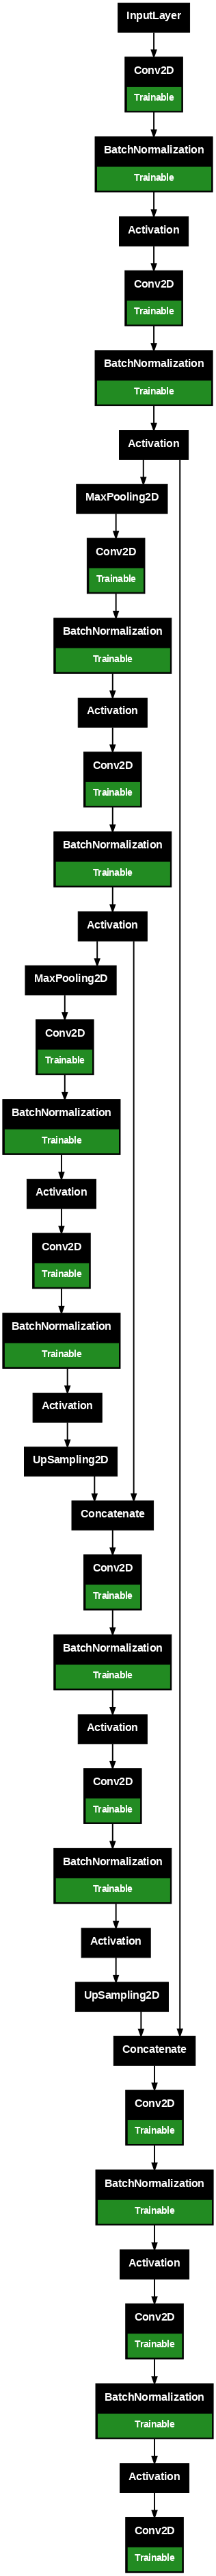

In [76]:
model = get_unet_model()

# Print a detailed summary of the model with expanded nested layers and trainable parameters.
model.summary(expand_nested=True, show_trainable=True)

# Generate and display a graphical representation of the model architecture.
tf.keras.utils.plot_model(model, show_trainable=True, expand_nested=True, dpi=70)

In [77]:
# used metric: Mean Intersection Over Union
class MeanIntersectionOverUnion(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes, labels_to_exclude=None, name="mean_iou", dtype=None):
        """
        Custom MeanIoU metric that can exclude certain labels (e.g., background).
        """
        super().__init__(num_classes=num_classes, name=name, dtype=dtype)
        self.labels_to_exclude = labels_to_exclude or []

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions to class labels
        y_pred = tf.math.argmax(y_pred, axis=-1)

        # Flatten the tensors
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])

        # Apply mask to exclude specified labels
        for label in self.labels_to_exclude:
            mask = tf.not_equal(y_true, label)
            y_true = tf.boolean_mask(y_true, mask)
            y_pred = tf.boolean_mask(y_pred, mask)

        # Update the state
        return super().update_state(y_true, y_pred, sample_weight)

In [78]:
# Compile the model
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.AdamW(1e-4),
    metrics=[tfk.metrics.MeanIoU(num_classes=NUM_CLASSES, ignore_class=0, sparse_y_pred=False, name="mean_iou"),
             "accuracy"]
)

# 🛠️ Train and Save the Model

In [79]:
# callback for visualization during training
class VizCallback(tf.keras.callbacks.Callback):
    def __init__(self, X, y, frequency=5):
        """
        Visualization callback to monitor predictions during training.

        Parameters:
        - X: NumPy array of input images.
        - y: NumPy array of ground truth masks.
        - frequency: How often (in epochs) to visualize predictions.
        """
        super().__init__()
        self.X = X
        self.y = y
        self.frequency = frequency

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.frequency == 0:  # Visualize every "frequency" epochs
            idx = 207  # Select the index of the image to plot
            image = self.X[idx]
            label = self.y[idx]

            # Add batch dimension to the image
            image_input = np.expand_dims(image, axis=0)
            pred = self.model.predict(image_input, verbose=0)
            y_pred = tf.math.argmax(pred, axis=-1).numpy()[0]  # Remove batch dimension

            # Create colormap
            num_classes = len(np.unique(self.y))  # Determine number of classes from the labels
            colormap = create_segmentation_colormap(num_classes)

            plt.figure(figsize=(16, 4))

            # Input image
            plt.subplot(1, 3, 1)
            plt.imshow(image, cmap='gray')
            plt.title("Input Image")
            plt.axis('off')

            # Ground truth
            plt.subplot(1, 3, 2)
            colored_label = apply_colormap(label, colormap)
            plt.imshow(colored_label)
            plt.title("Ground Truth Mask")
            plt.axis('off')

            # Prediction
            plt.subplot(1, 3, 3)
            colored_pred = apply_colormap(y_pred, colormap)
            plt.imshow(colored_pred)
            plt.title("Predicted Mask")
            plt.axis('off')

            add_colormap_legend(colormap, NUM_CLASSES, labels_name)

            plt.tight_layout()
            plt.show()
            plt.close()

In [80]:
# Setup callbacks
early_stopping = tfk.callbacks.EarlyStopping(monitor='val_mean_iou', patience=20, mode='max', restore_best_weights=True)
lr_scheduling = tfk.callbacks.ReduceLROnPlateau(monitor='val_mean_iou', factor=0.5, patience=15, min_lr=1e-6, min_delta=4e-6)
viz_callback = VizCallback(X_val, y_val, frequency=5)

Epoch 1/200
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.2678 - loss: 1.7036 - mean_iou: 0.1160

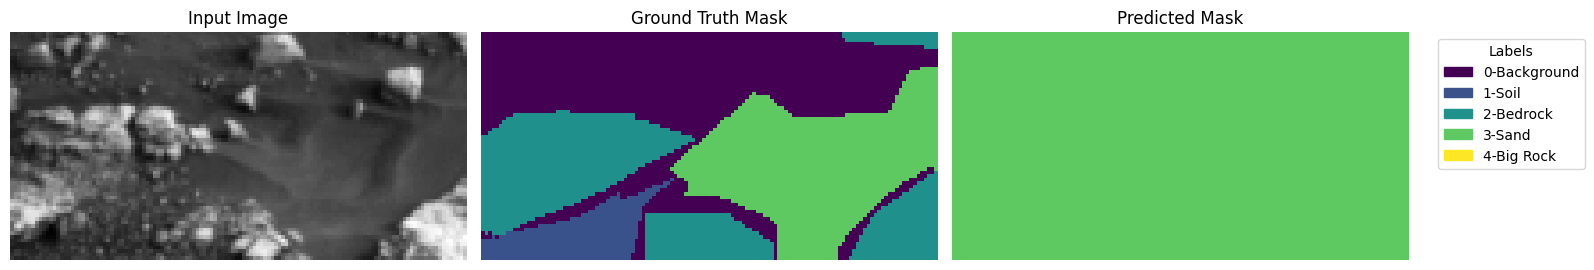

67/67 ━━━━━━━━━━━━━━━━━━━━ 24s 188ms/step - accuracy: 0.2690 - loss: 1.7013 - mean_iou: 0.1166 - val_accuracy: 0.2034 - val_loss: 1.6678 - val_mean_iou: 0.0656 - learning_rate: 1.0000e-04
Epoch 2/200
67/67 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - accuracy: 0.4834 - loss: 1.3462 - mean_iou: 0.2287 - val_accuracy: 0.2034 - val_loss: 2.1189 - val_mean_iou: 0.0656 - learning_rate: 1.0000e-04
Epoch 3/200
67/67 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - accuracy: 0.5783 - loss: 1.1832 - mean_iou: 0.3012 - val_accuracy: 0.2034 - val_loss: 2.6934 - val_mean_iou: 0.0656 - learning_rate: 1.0000e-04
Epoch 4/200
67/67 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - accuracy: 0.6089 - loss: 1.1024 - mean_iou: 0.3269 - val_accuracy: 0.2034 - val_loss: 3.2552 - val_mean_iou: 0.0656 - learning_rate: 1.0000e-04
Epoch 5/200
67/67 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.6228 - loss: 1.0540 - mean_iou: 0.3386 - val_accuracy: 0.2034 - val_loss: 3.3128 - val_mean_iou: 0.0656 - learning_rate: 1.0000e-04
Epoch 6/200
66/67 ━━

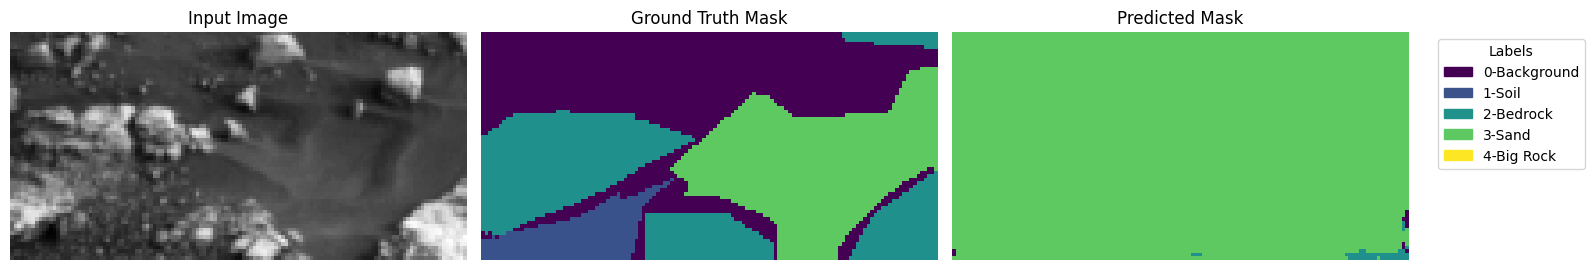

67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - accuracy: 0.6331 - loss: 1.0167 - mean_iou: 0.3468 - val_accuracy: 0.2040 - val_loss: 3.0165 - val_mean_iou: 0.0527 - learning_rate: 1.0000e-04
Epoch 7/200
67/67 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - accuracy: 0.6418 - loss: 0.9849 - mean_iou: 0.3534 - val_accuracy: 0.2592 - val_loss: 2.3258 - val_mean_iou: 0.0945 - learning_rate: 1.0000e-04
Epoch 8/200
67/67 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - accuracy: 0.6511 - loss: 0.9575 - mean_iou: 0.3614 - val_accuracy: 0.3962 - val_loss: 1.6839 - val_mean_iou: 0.1967 - learning_rate: 1.0000e-04
Epoch 9/200
67/67 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - accuracy: 0.6570 - loss: 0.9368 - mean_iou: 0.3659 - val_accuracy: 0.5084 - val_loss: 1.2745 - val_mean_iou: 0.2707 - learning_rate: 1.0000e-04
Epoch 10/200
67/67 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - accuracy: 0.6608 - loss: 0.9203 - mean_iou: 0.3688 - val_accuracy: 0.5821 - val_loss: 1.0473 - val_mean_iou: 0.3230 - learning_rate: 1.0000e-04
Epoch 11/200
66/67 ━━

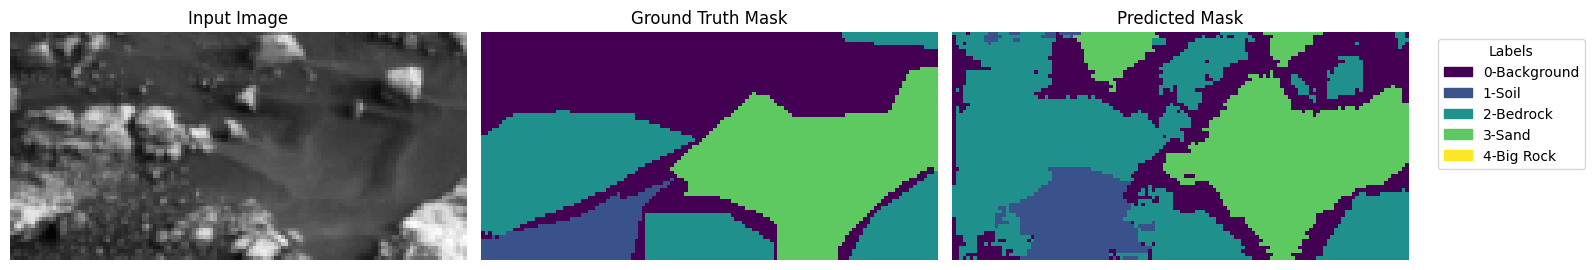

67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - accuracy: 0.6637 - loss: 0.9062 - mean_iou: 0.3713 - val_accuracy: 0.5585 - val_loss: 1.1338 - val_mean_iou: 0.3012 - learning_rate: 1.0000e-04
Epoch 12/200
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.6686 - loss: 0.8897 - mean_iou: 0.3753 - val_accuracy: 0.5710 - val_loss: 1.0980 - val_mean_iou: 0.2997 - learning_rate: 1.0000e-04
Epoch 13/200
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - accuracy: 0.6741 - loss: 0.8737 - mean_iou: 0.3793 - val_accuracy: 0.5414 - val_loss: 1.2132 - val_mean_iou: 0.2722 - learning_rate: 1.0000e-04
Epoch 14/200
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - accuracy: 0.6786 - loss: 0.8600 - mean_iou: 0.3828 - val_accuracy: 0.6031 - val_loss: 1.0376 - val_mean_iou: 0.3234 - learning_rate: 1.0000e-04
Epoch 15/200
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - accuracy: 0.6825 - loss: 0.8476 - mean_iou: 0.3860 - val_accuracy: 0.6074 - val_loss: 1.0253 - val_mean_iou: 0.3265 - learning_rate: 1.0000e-04
Epoch 16/200
66/67

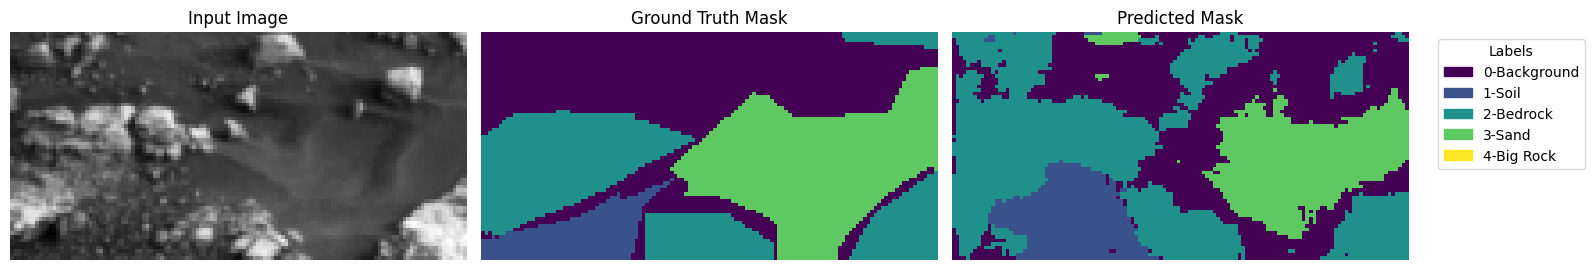

67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - accuracy: 0.6861 - loss: 0.8361 - mean_iou: 0.3892 - val_accuracy: 0.6349 - val_loss: 0.9453 - val_mean_iou: 0.3526 - learning_rate: 1.0000e-04
Epoch 17/200
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - accuracy: 0.6893 - loss: 0.8259 - mean_iou: 0.3919 - val_accuracy: 0.6090 - val_loss: 1.0106 - val_mean_iou: 0.3196 - learning_rate: 1.0000e-04
Epoch 18/200
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.6925 - loss: 0.8165 - mean_iou: 0.3944 - val_accuracy: 0.6106 - val_loss: 1.0126 - val_mean_iou: 0.3254 - learning_rate: 1.0000e-04
Epoch 19/200
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - accuracy: 0.6951 - loss: 0.8082 - mean_iou: 0.3960 - val_accuracy: 0.6076 - val_loss: 1.0112 - val_mean_iou: 0.3220 - learning_rate: 1.0000e-04
Epoch 20/200
67/67 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.6985 - loss: 0.7992 - mean_iou: 0.3988 - val_accuracy: 0.6368 - val_loss: 0.9499 - val_mean_iou: 0.3454 - learning_rate: 1.0000e-04
Epoch 21/200
66/67

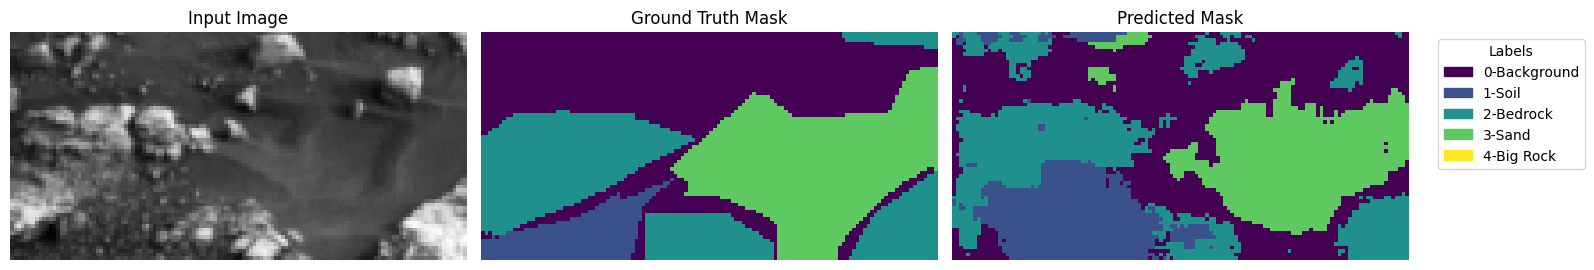

67/67 ━━━━━━━━━━━━━━━━━━━━ 6s 74ms/step - accuracy: 0.7005 - loss: 0.7930 - mean_iou: 0.3999 - val_accuracy: 0.6546 - val_loss: 0.9014 - val_mean_iou: 0.3633 - learning_rate: 1.0000e-04
Epoch 22/200
67/67 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - accuracy: 0.7027 - loss: 0.7837 - mean_iou: 0.4025 - val_accuracy: 0.6627 - val_loss: 0.8670 - val_mean_iou: 0.3821 - learning_rate: 5.0000e-05
Epoch 23/200
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.7051 - loss: 0.7773 - mean_iou: 0.4061 - val_accuracy: 0.6820 - val_loss: 0.8323 - val_mean_iou: 0.3963 - learning_rate: 5.0000e-05
Epoch 24/200
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - accuracy: 0.7076 - loss: 0.7708 - mean_iou: 0.4073 - val_accuracy: 0.6802 - val_loss: 0.8358 - val_mean_iou: 0.3903 - learning_rate: 5.0000e-05
Epoch 25/200
67/67 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - accuracy: 0.7092 - loss: 0.7661 - mean_iou: 0.4085 - val_accuracy: 0.6892 - val_loss: 0.8204 - val_mean_iou: 0.3970 - learning_rate: 5.0000e-05
Epoch 26/200
66/67

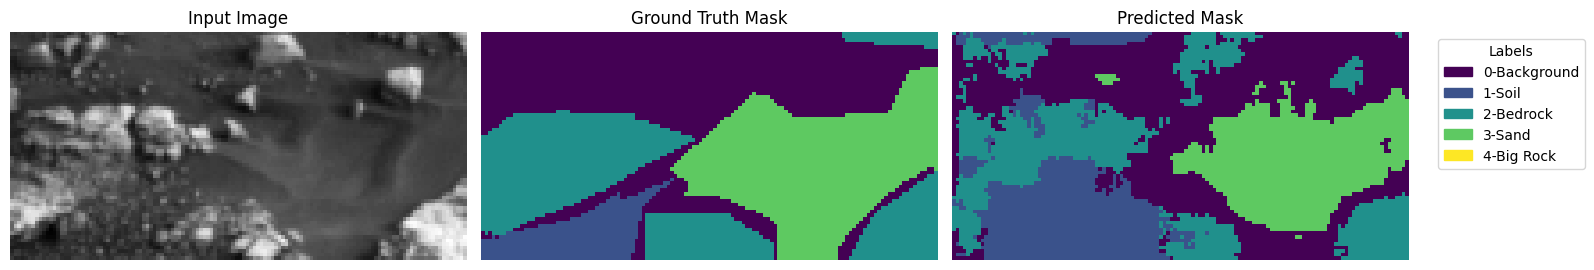

67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - accuracy: 0.7107 - loss: 0.7619 - mean_iou: 0.4097 - val_accuracy: 0.6625 - val_loss: 0.8890 - val_mean_iou: 0.3663 - learning_rate: 5.0000e-05
Epoch 27/200
67/67 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.7121 - loss: 0.7581 - mean_iou: 0.4106 - val_accuracy: 0.6660 - val_loss: 0.8798 - val_mean_iou: 0.3723 - learning_rate: 5.0000e-05
Epoch 28/200
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - accuracy: 0.7133 - loss: 0.7545 - mean_iou: 0.4115 - val_accuracy: 0.6627 - val_loss: 0.8886 - val_mean_iou: 0.3692 - learning_rate: 5.0000e-05
Epoch 29/200
67/67 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.7146 - loss: 0.7510 - mean_iou: 0.4125 - val_accuracy: 0.6469 - val_loss: 0.9188 - val_mean_iou: 0.3497 - learning_rate: 5.0000e-05
Epoch 30/200
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - accuracy: 0.7159 - loss: 0.7472 - mean_iou: 0.4136 - val_accuracy: 0.6892 - val_loss: 0.8293 - val_mean_iou: 0.3987 - learning_rate: 5.0000e-05
Epoch 31/200
66/67

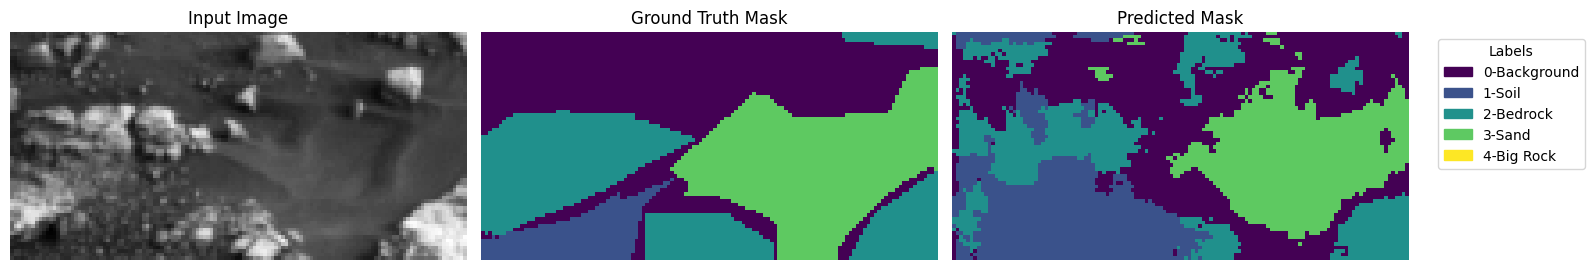

67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - accuracy: 0.7173 - loss: 0.7434 - mean_iou: 0.4147 - val_accuracy: 0.7028 - val_loss: 0.7900 - val_mean_iou: 0.4150 - learning_rate: 5.0000e-05
Epoch 32/200
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.7187 - loss: 0.7395 - mean_iou: 0.4159 - val_accuracy: 0.6916 - val_loss: 0.8271 - val_mean_iou: 0.3986 - learning_rate: 5.0000e-05
Epoch 33/200
67/67 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.7201 - loss: 0.7357 - mean_iou: 0.4170 - val_accuracy: 0.6879 - val_loss: 0.8465 - val_mean_iou: 0.3957 - learning_rate: 5.0000e-05
Epoch 34/200
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.7215 - loss: 0.7318 - mean_iou: 0.4182 - val_accuracy: 0.6687 - val_loss: 0.8915 - val_mean_iou: 0.3751 - learning_rate: 5.0000e-05
Epoch 35/200
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.7229 - loss: 0.7281 - mean_iou: 0.4193 - val_accuracy: 0.6474 - val_loss: 0.9361 - val_mean_iou: 0.3550 - learning_rate: 5.0000e-05
Epoch 36/200
66/67

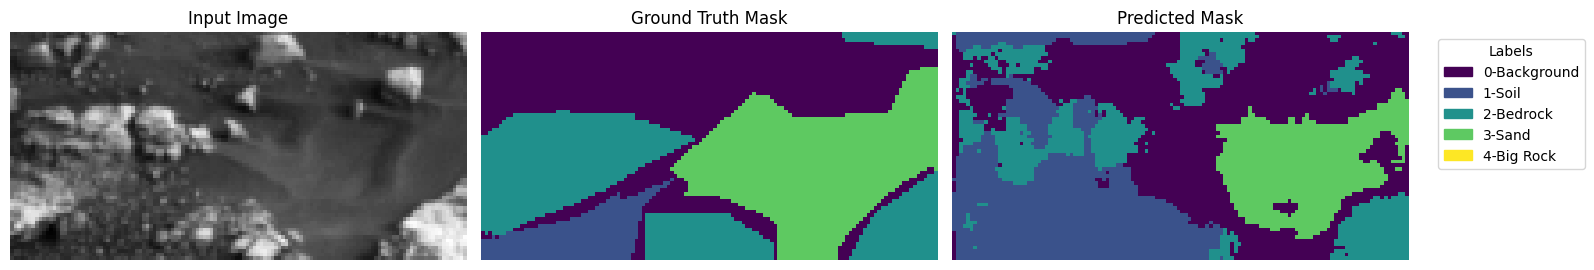

67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - accuracy: 0.7243 - loss: 0.7244 - mean_iou: 0.4203 - val_accuracy: 0.6812 - val_loss: 0.8619 - val_mean_iou: 0.3949 - learning_rate: 5.0000e-05
Epoch 37/200
67/67 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.7270 - loss: 0.7182 - mean_iou: 0.4231 - val_accuracy: 0.7036 - val_loss: 0.7881 - val_mean_iou: 0.4076 - learning_rate: 2.5000e-05
Epoch 38/200
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.7329 - loss: 0.7075 - mean_iou: 0.4292 - val_accuracy: 0.7029 - val_loss: 0.7925 - val_mean_iou: 0.4075 - learning_rate: 2.5000e-05
Epoch 39/200
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - accuracy: 0.7345 - loss: 0.7035 - mean_iou: 0.4307 - val_accuracy: 0.7061 - val_loss: 0.7796 - val_mean_iou: 0.4141 - learning_rate: 2.5000e-05
Epoch 40/200
67/67 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.7357 - loss: 0.7005 - mean_iou: 0.4317 - val_accuracy: 0.6990 - val_loss: 0.7917 - val_mean_iou: 0.4070 - learning_rate: 2.5000e-05
Epoch 41/200
66/67

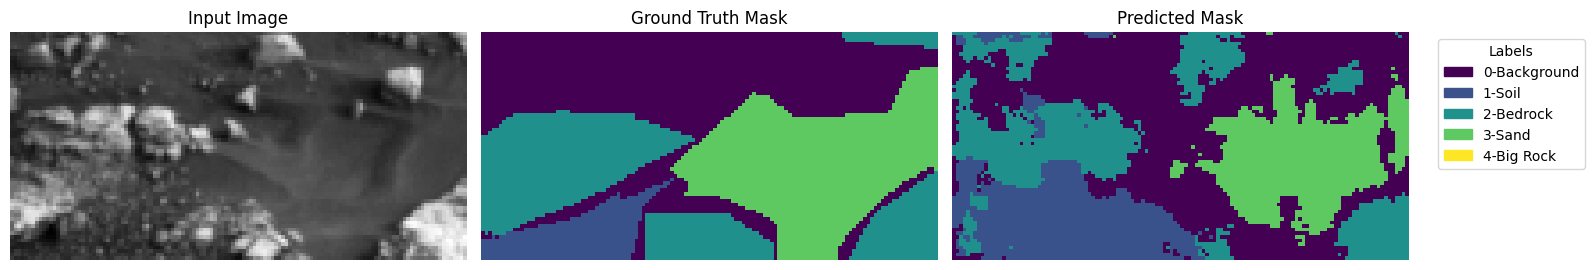

67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - accuracy: 0.7368 - loss: 0.6977 - mean_iou: 0.4326 - val_accuracy: 0.7045 - val_loss: 0.7813 - val_mean_iou: 0.4121 - learning_rate: 2.5000e-05
Epoch 42/200
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - accuracy: 0.7378 - loss: 0.6951 - mean_iou: 0.4335 - val_accuracy: 0.7052 - val_loss: 0.7824 - val_mean_iou: 0.4123 - learning_rate: 2.5000e-05
Epoch 43/200
67/67 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.7388 - loss: 0.6927 - mean_iou: 0.4343 - val_accuracy: 0.7053 - val_loss: 0.7802 - val_mean_iou: 0.4106 - learning_rate: 2.5000e-05
Epoch 44/200
67/67 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.7397 - loss: 0.6903 - mean_iou: 0.4351 - val_accuracy: 0.7066 - val_loss: 0.7770 - val_mean_iou: 0.4111 - learning_rate: 2.5000e-05
Epoch 45/200
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - accuracy: 0.7406 - loss: 0.6879 - mean_iou: 0.4359 - val_accuracy: 0.7072 - val_loss: 0.7762 - val_mean_iou: 0.4112 - learning_rate: 2.5000e-05
Epoch 46/200
66/67

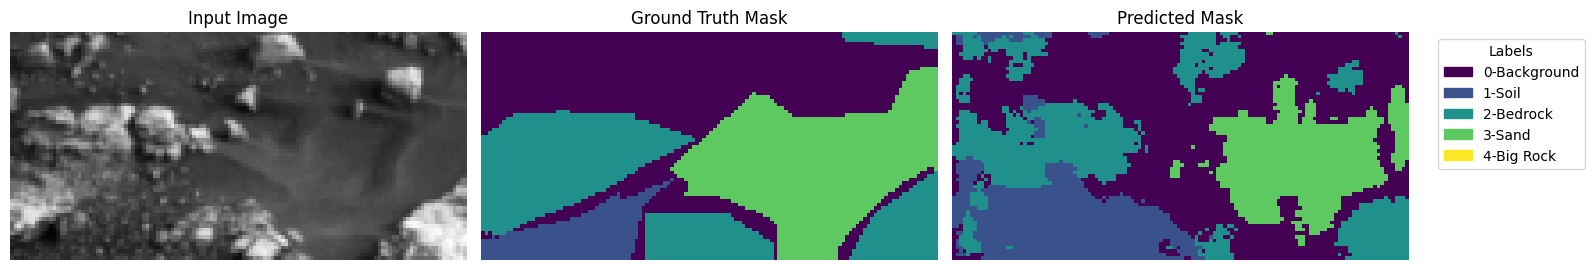

67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - accuracy: 0.7415 - loss: 0.6857 - mean_iou: 0.4367 - val_accuracy: 0.7088 - val_loss: 0.7732 - val_mean_iou: 0.4127 - learning_rate: 2.5000e-05
Epoch 47/200
67/67 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - accuracy: 0.7423 - loss: 0.6834 - mean_iou: 0.4374 - val_accuracy: 0.7083 - val_loss: 0.7748 - val_mean_iou: 0.4107 - learning_rate: 2.5000e-05
Epoch 48/200
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - accuracy: 0.7431 - loss: 0.6812 - mean_iou: 0.4382 - val_accuracy: 0.7110 - val_loss: 0.7656 - val_mean_iou: 0.4151 - learning_rate: 2.5000e-05
Epoch 49/200
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - accuracy: 0.7439 - loss: 0.6790 - mean_iou: 0.4389 - val_accuracy: 0.7106 - val_loss: 0.7705 - val_mean_iou: 0.4132 - learning_rate: 2.5000e-05
Epoch 50/200
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - accuracy: 0.7446 - loss: 0.6769 - mean_iou: 0.4395 - val_accuracy: 0.7111 - val_loss: 0.7705 - val_mean_iou: 0.4152 - learning_rate: 2.5000e-05
Epoch 51/200
66/67

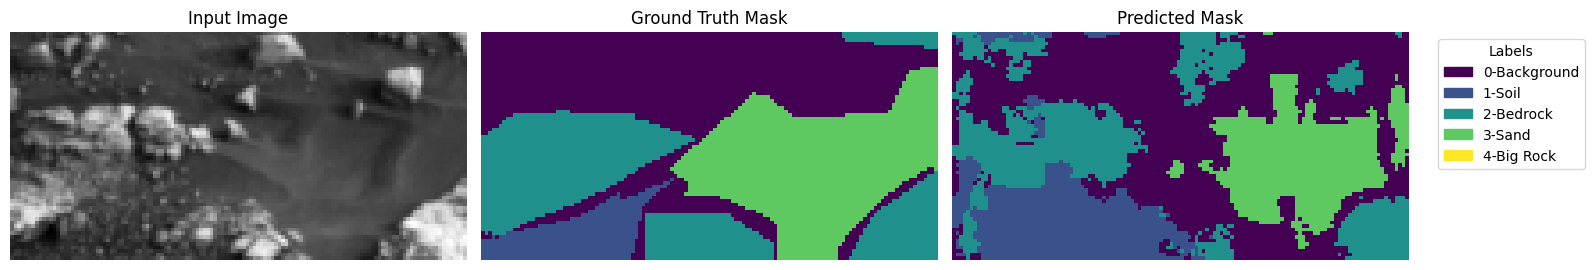

67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - accuracy: 0.7454 - loss: 0.6748 - mean_iou: 0.4402 - val_accuracy: 0.7119 - val_loss: 0.7636 - val_mean_iou: 0.4182 - learning_rate: 2.5000e-05
Epoch 52/200
67/67 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - accuracy: 0.7469 - loss: 0.6703 - mean_iou: 0.4422 - val_accuracy: 0.7180 - val_loss: 0.7491 - val_mean_iou: 0.4231 - learning_rate: 1.2500e-05
Epoch 53/200
67/67 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - accuracy: 0.7472 - loss: 0.6691 - mean_iou: 0.4423 - val_accuracy: 0.7187 - val_loss: 0.7487 - val_mean_iou: 0.4228 - learning_rate: 1.2500e-05
Epoch 54/200
67/67 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.7478 - loss: 0.6673 - mean_iou: 0.4429 - val_accuracy: 0.7190 - val_loss: 0.7470 - val_mean_iou: 0.4221 - learning_rate: 1.2500e-05
Epoch 55/200
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - accuracy: 0.7484 - loss: 0.6657 - mean_iou: 0.4434 - val_accuracy: 0.7187 - val_loss: 0.7478 - val_mean_iou: 0.4230 - learning_rate: 1.2500e-05
Epoch 56/200
66/67

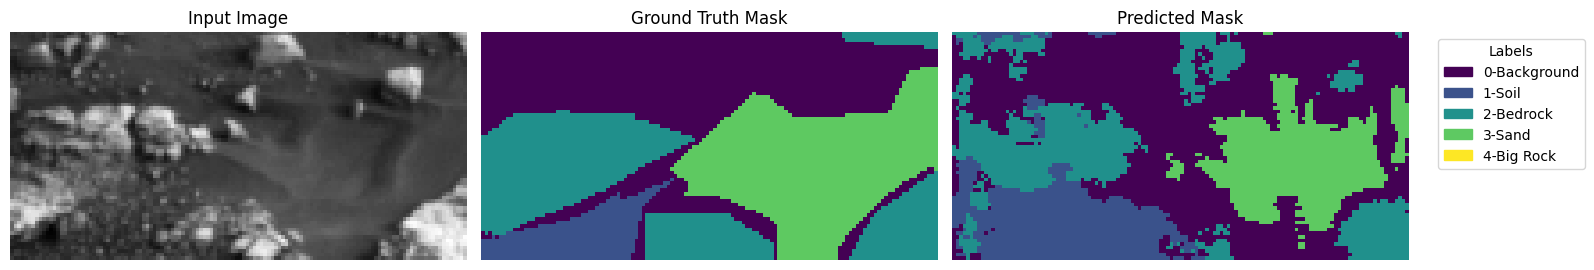

67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - accuracy: 0.7489 - loss: 0.6642 - mean_iou: 0.4439 - val_accuracy: 0.7201 - val_loss: 0.7466 - val_mean_iou: 0.4234 - learning_rate: 1.2500e-05
Epoch 57/200
67/67 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - accuracy: 0.7494 - loss: 0.6628 - mean_iou: 0.4444 - val_accuracy: 0.7194 - val_loss: 0.7474 - val_mean_iou: 0.4231 - learning_rate: 1.2500e-05
Epoch 58/200
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - accuracy: 0.7499 - loss: 0.6615 - mean_iou: 0.4448 - val_accuracy: 0.7200 - val_loss: 0.7477 - val_mean_iou: 0.4238 - learning_rate: 1.2500e-05
Epoch 59/200
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - accuracy: 0.7503 - loss: 0.6602 - mean_iou: 0.4452 - val_accuracy: 0.7190 - val_loss: 0.7492 - val_mean_iou: 0.4233 - learning_rate: 1.2500e-05
Epoch 60/200
67/67 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.7508 - loss: 0.6589 - mean_iou: 0.4457 - val_accuracy: 0.7205 - val_loss: 0.7483 - val_mean_iou: 0.4249 - learning_rate: 1.2500e-05
Epoch 61/200
66/67

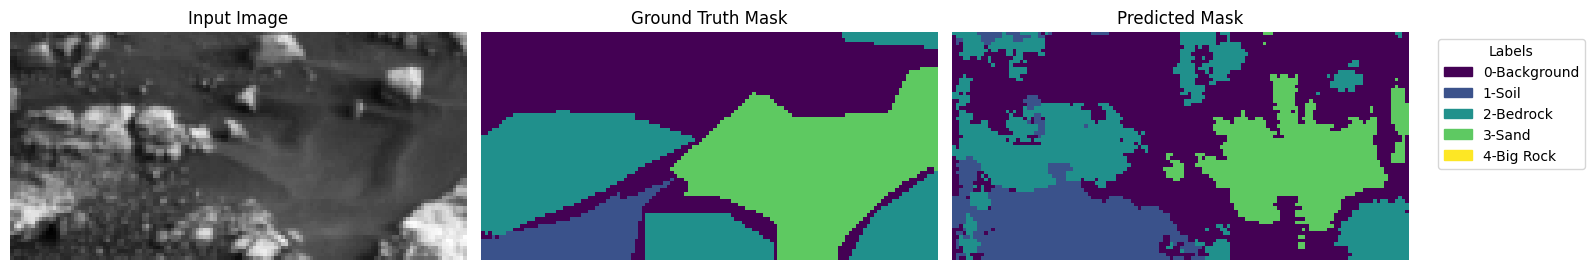

67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - accuracy: 0.7512 - loss: 0.6576 - mean_iou: 0.4461 - val_accuracy: 0.7200 - val_loss: 0.7463 - val_mean_iou: 0.4229 - learning_rate: 1.2500e-05
Epoch 62/200
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - accuracy: 0.7517 - loss: 0.6564 - mean_iou: 0.4465 - val_accuracy: 0.7192 - val_loss: 0.7485 - val_mean_iou: 0.4224 - learning_rate: 1.2500e-05
Epoch 63/200
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - accuracy: 0.7521 - loss: 0.6552 - mean_iou: 0.4469 - val_accuracy: 0.7202 - val_loss: 0.7467 - val_mean_iou: 0.4240 - learning_rate: 1.2500e-05
Epoch 64/200
67/67 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - accuracy: 0.7525 - loss: 0.6540 - mean_iou: 0.4473 - val_accuracy: 0.7181 - val_loss: 0.7477 - val_mean_iou: 0.4219 - learning_rate: 1.2500e-05
Epoch 65/200
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - accuracy: 0.7529 - loss: 0.6529 - mean_iou: 0.4477 - val_accuracy: 0.7190 - val_loss: 0.7477 - val_mean_iou: 0.4229 - learning_rate: 1.2500e-05
Epoch 66/200
66/67

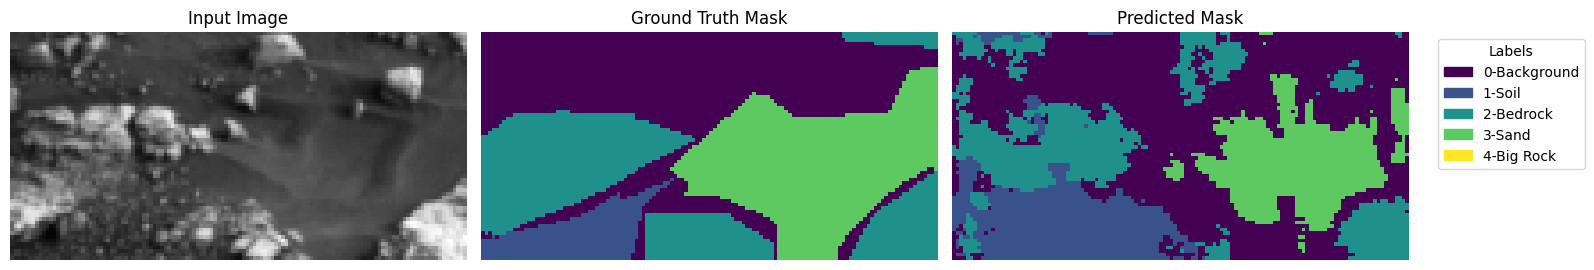

67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - accuracy: 0.7533 - loss: 0.6517 - mean_iou: 0.4480 - val_accuracy: 0.7208 - val_loss: 0.7466 - val_mean_iou: 0.4243 - learning_rate: 1.2500e-05
Epoch 67/200
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - accuracy: 0.7540 - loss: 0.6490 - mean_iou: 0.4491 - val_accuracy: 0.7250 - val_loss: 0.7344 - val_mean_iou: 0.4257 - learning_rate: 6.2500e-06
Epoch 68/200
67/67 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.7552 - loss: 0.6458 - mean_iou: 0.4499 - val_accuracy: 0.7248 - val_loss: 0.7348 - val_mean_iou: 0.4252 - learning_rate: 6.2500e-06
Epoch 69/200
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - accuracy: 0.7555 - loss: 0.6450 - mean_iou: 0.4502 - val_accuracy: 0.7250 - val_loss: 0.7341 - val_mean_iou: 0.4256 - learning_rate: 6.2500e-06
Epoch 70/200
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - accuracy: 0.7558 - loss: 0.6443 - mean_iou: 0.4504 - val_accuracy: 0.7251 - val_loss: 0.7342 - val_mean_iou: 0.4262 - learning_rate: 6.2500e-06
Epoch 71/200
66/67

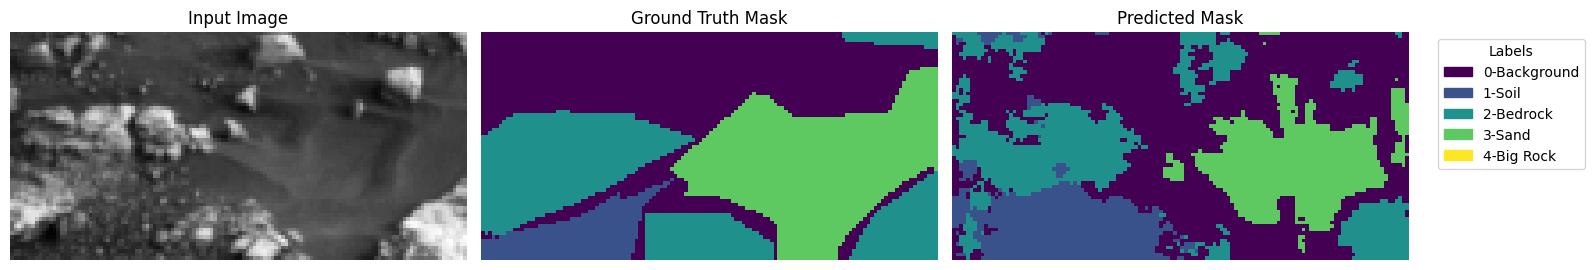

67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - accuracy: 0.7560 - loss: 0.6436 - mean_iou: 0.4506 - val_accuracy: 0.7250 - val_loss: 0.7330 - val_mean_iou: 0.4261 - learning_rate: 6.2500e-06
Epoch 72/200
67/67 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - accuracy: 0.7562 - loss: 0.6430 - mean_iou: 0.4508 - val_accuracy: 0.7248 - val_loss: 0.7326 - val_mean_iou: 0.4252 - learning_rate: 6.2500e-06
Epoch 73/200
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - accuracy: 0.7565 - loss: 0.6424 - mean_iou: 0.4510 - val_accuracy: 0.7251 - val_loss: 0.7332 - val_mean_iou: 0.4259 - learning_rate: 6.2500e-06
Epoch 74/200
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - accuracy: 0.7567 - loss: 0.6418 - mean_iou: 0.4513 - val_accuracy: 0.7248 - val_loss: 0.7340 - val_mean_iou: 0.4251 - learning_rate: 6.2500e-06
Epoch 75/200
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.7569 - loss: 0.6412 - mean_iou: 0.4515 - val_accuracy: 0.7247 - val_loss: 0.7337 - val_mean_iou: 0.4248 - learning_rate: 6.2500e-06
Epoch 76/200
66/67

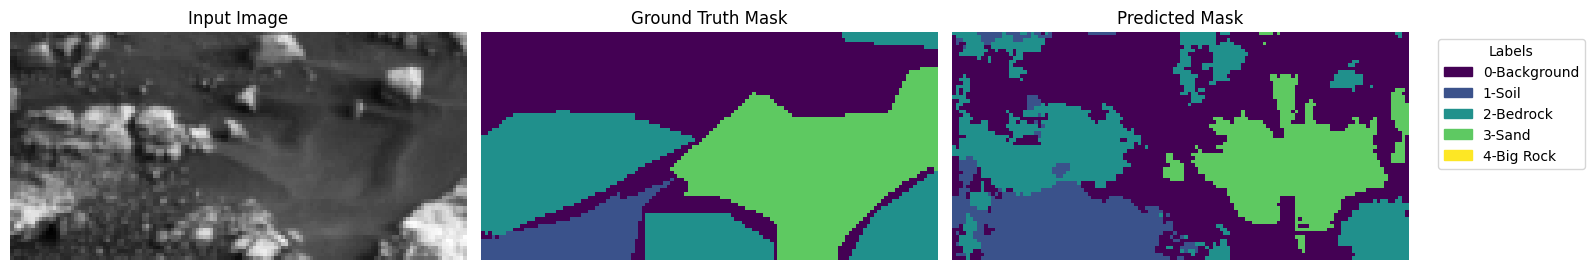

67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - accuracy: 0.7571 - loss: 0.6406 - mean_iou: 0.4516 - val_accuracy: 0.7249 - val_loss: 0.7338 - val_mean_iou: 0.4253 - learning_rate: 6.2500e-06
Epoch 77/200
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - accuracy: 0.7573 - loss: 0.6400 - mean_iou: 0.4518 - val_accuracy: 0.7250 - val_loss: 0.7347 - val_mean_iou: 0.4255 - learning_rate: 6.2500e-06
Epoch 78/200
67/67 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.7575 - loss: 0.6394 - mean_iou: 0.4520 - val_accuracy: 0.7252 - val_loss: 0.7337 - val_mean_iou: 0.4261 - learning_rate: 6.2500e-06
Epoch 79/200
67/67 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.7578 - loss: 0.6388 - mean_iou: 0.4522 - val_accuracy: 0.7248 - val_loss: 0.7346 - val_mean_iou: 0.4249 - learning_rate: 6.2500e-06
Epoch 80/200
67/67 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - accuracy: 0.7580 - loss: 0.6382 - mean_iou: 0.4524 - val_accuracy: 0.7248 - val_loss: 0.7336 - val_mean_iou: 0.4251 - learning_rate: 6.2500e-06
Epoch 81/200
66/67

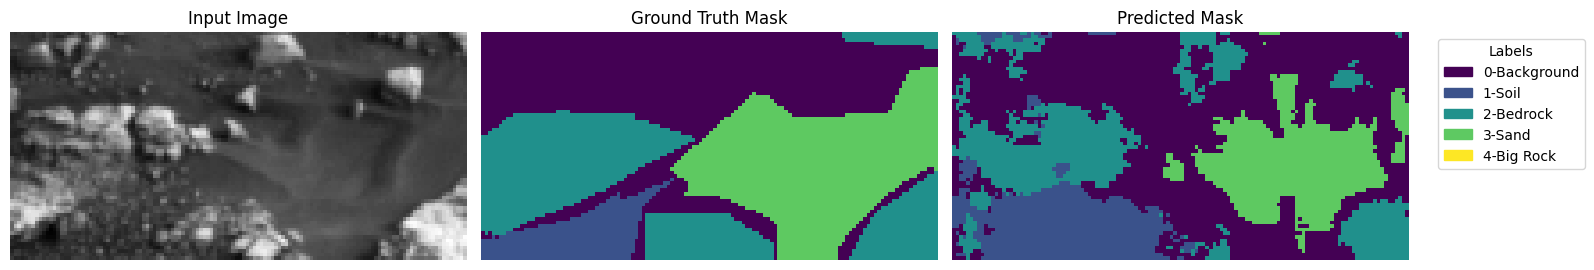

67/67 ━━━━━━━━━━━━━━━━━━━━ 6s 71ms/step - accuracy: 0.7582 - loss: 0.6376 - mean_iou: 0.4526 - val_accuracy: 0.7251 - val_loss: 0.7335 - val_mean_iou: 0.4251 - learning_rate: 6.2500e-06
Epoch 82/200
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.7585 - loss: 0.6363 - mean_iou: 0.4530 - val_accuracy: 0.7263 - val_loss: 0.7316 - val_mean_iou: 0.4254 - learning_rate: 3.1250e-06
Epoch 83/200
67/67 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - accuracy: 0.7593 - loss: 0.6344 - mean_iou: 0.4536 - val_accuracy: 0.7263 - val_loss: 0.7313 - val_mean_iou: 0.4255 - learning_rate: 3.1250e-06
Epoch 84/200
67/67 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - accuracy: 0.7595 - loss: 0.6339 - mean_iou: 0.4537 - val_accuracy: 0.7263 - val_loss: 0.7311 - val_mean_iou: 0.4255 - learning_rate: 3.1250e-06
Epoch 85/200
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - accuracy: 0.7596 - loss: 0.6335 - mean_iou: 0.4539 - val_accuracy: 0.7265 - val_loss: 0.7309 - val_mean_iou: 0.4259 - learning_rate: 3.1250e-06
Epoch 86/200
66/67

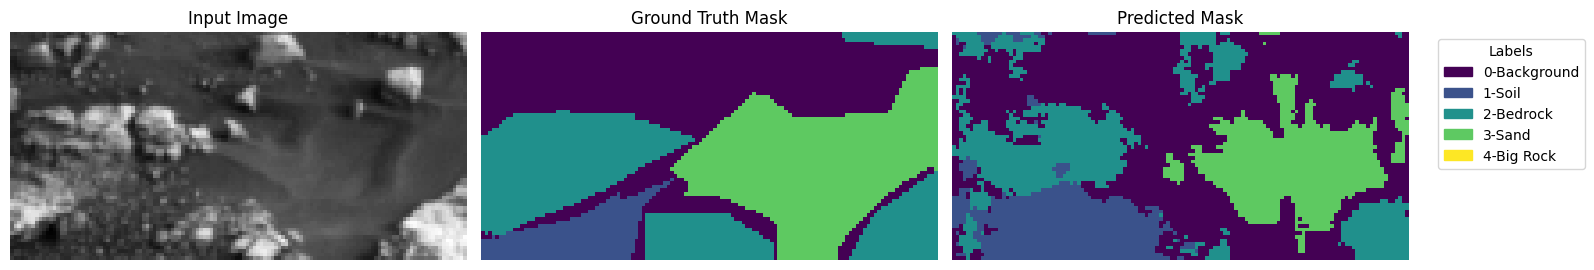

67/67 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step - accuracy: 0.7598 - loss: 0.6332 - mean_iou: 0.4540 - val_accuracy: 0.7263 - val_loss: 0.7308 - val_mean_iou: 0.4257 - learning_rate: 3.1250e-06
Epoch 87/200
67/67 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.7599 - loss: 0.6329 - mean_iou: 0.4541 - val_accuracy: 0.7262 - val_loss: 0.7308 - val_mean_iou: 0.4258 - learning_rate: 3.1250e-06
Epoch 88/200
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.7600 - loss: 0.6325 - mean_iou: 0.4542 - val_accuracy: 0.7263 - val_loss: 0.7310 - val_mean_iou: 0.4255 - learning_rate: 3.1250e-06
Epoch 89/200
67/67 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - accuracy: 0.7601 - loss: 0.6322 - mean_iou: 0.4543 - val_accuracy: 0.7264 - val_loss: 0.7314 - val_mean_iou: 0.4257 - learning_rate: 3.1250e-06
Epoch 90/200
67/67 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.7602 - loss: 0.6319 - mean_iou: 0.4544 - val_accuracy: 0.7265 - val_loss: 0.7313 - val_mean_iou: 0.4258 - learning_rate: 3.1250e-06
Final validation M

In [81]:
# Train the model
history = model.fit(
    X_train, y_train,
    epochs=200,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping,lr_scheduling, viz_callback],
    verbose=1
).history

# Calculate and print the final validation Mean Intersection Over Union
final_val_mean_iou = max(history['val_mean_iou'])* 100
print(f'Final validation Mean Intersection Over Union: {final_val_mean_iou} %')

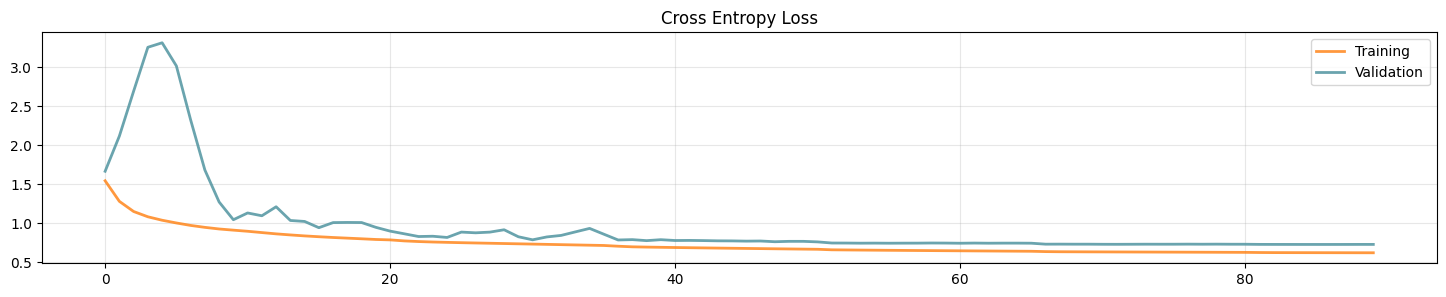

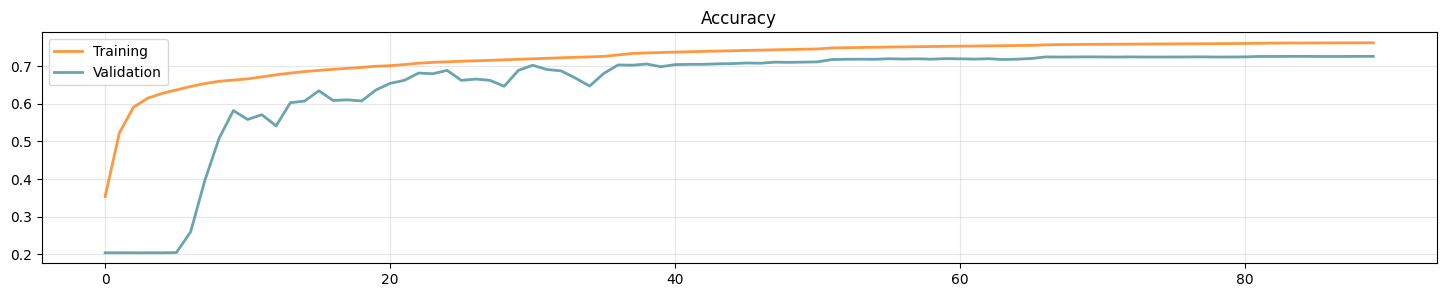

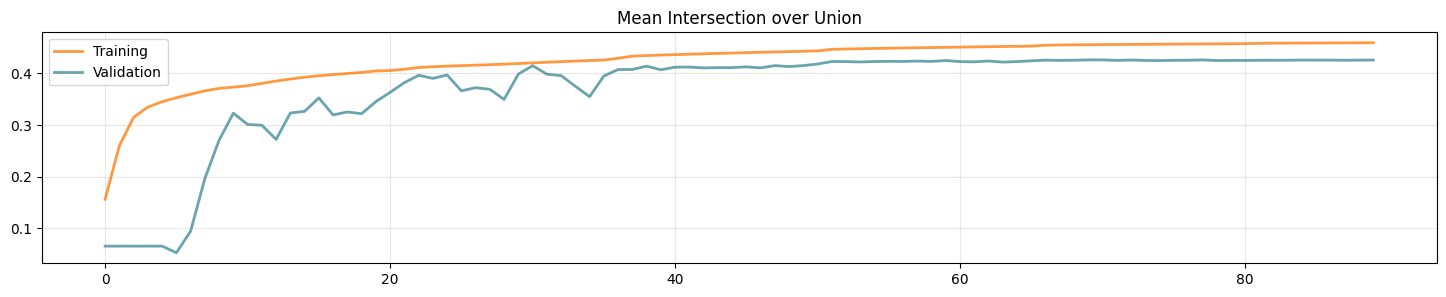

In [82]:
# Plot and display training and validation loss
plt.figure(figsize=(18, 3))
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_loss'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Cross Entropy Loss')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation accuracy
plt.figure(figsize=(18, 3))
plt.plot(history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_accuracy'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation mean IoU
plt.figure(figsize=(18, 3))
plt.plot(history['mean_iou'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_mean_iou'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Mean Intersection over Union')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [83]:
# save the model and remove it from memory

timestep_str = datetime.now().strftime("%y%m%d_%H%M%S")
model_filename = f"model_{timestep_str}.keras"
model.save(model_filename)
del model

print(f"Model saved to {model_filename}")

Model saved to model_241130_153030.keras


# 📊 Submission

In our Kaggle competition, submissions are made as `csv` files. To create a proper `csv` file, you need to flatten your predictions and include an `id` column as the first column of your dataframe. To maintain consistency between your results and our solution, please avoid shuffling the test set. The code below demonstrates how to prepare the `csv` file from your model predictions.




In [84]:
# If model_filename is not defined, load the most recent model from Google Drive
if "model_filename" not in globals() or model_filename is None:
    files = [f for f in os.listdir('.') if os.path.isfile(f) and f.startswith('model_') and f.endswith('.keras')]
    files.sort(key=lambda x: os.path.getmtime(x), reverse=True)
    if files:
        model_filename = files[0]
    else:
        raise FileNotFoundError("No model files found in the current directory.")

In [85]:
model = tfk.models.load_model(model_filename)
print(f"Model loaded from {model_filename}")

Model loaded from model_241130_153030.keras


In [86]:
preds = model.predict(X_test)
preds = np.argmax(preds, axis=-1)
print(f"Predictions shape: {preds.shape}")

314/314 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step
Predictions shape: (10022, 64, 128)


In [87]:
def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [88]:
# Create and download the csv submission file
timestep_str = model_filename.replace("model_", "").replace(".keras", "")
submission_filename = f"submission_{timestep_str}.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)

from google.colab import files
files.download(submission_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>